# Określanie pozy obiektu

<img src="pnp.jpg" alt="Drawing" style="width: 800px;"/>

&nbsp;
###  Określanie pozy obiektu - chcemy uzyskać rotację (macierz rotacji/kwaterniony/kąty eulera) oraz translację (x,y,z) obiektu względem kamery, która jest skalibrowana - f_x, f_y, u_0, v_0.
&nbsp;

<img src="wzor.svg" alt="Drawing" style="width: 800px;"/>

### Estymowaliśmy pozę (przy pomocy sieci/PnP/innego algorytmu) -> co dalej?
&nbsp;
&nbsp;
&nbsp;

### W jaki sposób określić jakość/dokładność ustalonej pozy?
&nbsp;
&nbsp;
&nbsp;
&nbsp;

# Wizualizacja pozy

### Prostopadłościany

<img src="035_power_drill_0054.png" alt="Drawing" style="width: 800px;"/>

### Rzutowanie maski/punktow obiektu

<img src="Figure_1_drill_crop.png" alt="Drawing" style="width: 800px;"/>

### Renderowanie obiektu

In [ ]:
#TODO dla chętnych

# Reprezentacja obiektu - chmura punktów

<img src="drill_chmura.png" alt="Drawing" style="width: 800px;"/>

### Wczytanie - ply

In [3]:
#wczytanie modelu jako chmury punktow
import plyfile
import numpy as np
# data = plyfile.PlyData.read('./YCB_Video/YCB_Video_ext/models/035_power_dril/power_drill_points.ply')['vertex']
data = plyfile.PlyData.read('./power_drill_points.ply')['vertex']
model_ply = np.c_[data['x'], data['y'], data['z']]

In [4]:
camera_matrix = np.load("./camera_matrix.npy")

In [5]:
def hamilton_product(quat_1,quat_2):
    quat_out = np.zeros(4)
    quat_out[0] = quat_1[0]*quat_2[0] - quat_1[1]*quat_2[1]-quat_1[2]*quat_2[2]-quat_1[3]*quat_2[3]
    quat_out[1] = quat_1[0]*quat_2[1] + quat_1[1]*quat_2[0]+quat_1[2]*quat_2[3]-quat_1[3]*quat_2[2]
    quat_out[2] = quat_1[0]*quat_2[2] - quat_1[1]*quat_2[3]+quat_1[2]*quat_2[0]+quat_1[3]*quat_2[1]
    quat_out[3] = quat_1[0]*quat_2[3] + quat_1[1]*quat_2[2]-quat_1[2]*quat_2[1]+quat_1[3]*quat_2[0]
    return quat_out

def rotate_quat(points, quat): #rotacja punktów przy pomocy kwaternionu
    # xyzw -> wxyz
    quat_wxyz = quat.copy()
    quat_wxyz[0] = quat[3]
    quat_wxyz[1:] = quat[:3]

    points_vec = np.zeros((points.shape[0],4))
    points_vec[:,1:] =  points

    quat_tmp = quat_wxyz.copy()
    quat_tmp[1:] = -quat_tmp[1:]
    quat_1 = quat_tmp/np.sqrt(quat_tmp[0]**2+quat_tmp[1]**2+quat_tmp[2]**2+quat_tmp[3]**2)
    #hamilton produkt qpq^-1
    points_out = np.zeros(points.shape)
    for i in range(points.shape[0]):
        points_out[i] = hamilton_product(hamilton_product(quat_wxyz,points_vec[i]),quat_1)[1:]

    return points_out

#rzutowanie punktów na zdjęcie
def project(pose, points, camera_matrix): # pose[quat(x,y,z,w), translation(x,y,z)], punkty[x,y,z], macierz kamery
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate_quat(points, pose[:4]) #rotation
    points_proj += pose[4:] #translation

    for i in range(points_proj.shape[0]):
        pixel_point = camera_matrix @ points_proj[i]
        points_proj[i,:2] = pixel_point[:2]/pixel_point[2]
    points_proj = points_proj[:,:2]
    return points_proj

In [6]:
import cv2
trainImg = cv2.imread("./000001-color.png")
trainImg= cv2.cvtColor(trainImg, cv2.COLOR_BGR2RGB)

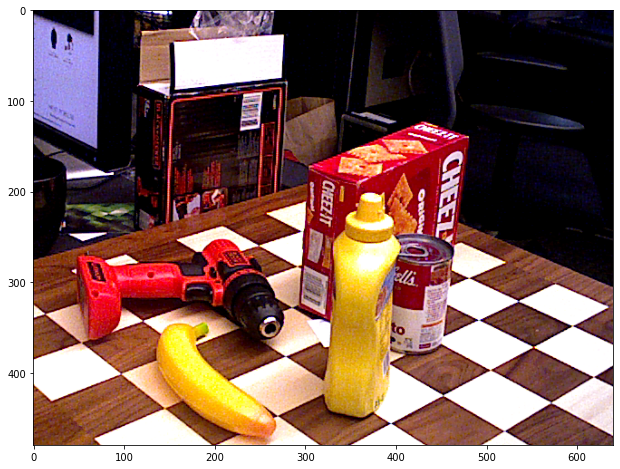

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,8))

plt.imshow(trainImg)
plt.show()

In [8]:
pose = np.array([0.30252337,  0.47923383,  0.65995039, -0.49323426, -0.11394919, 0.05734401,  0.96302502])

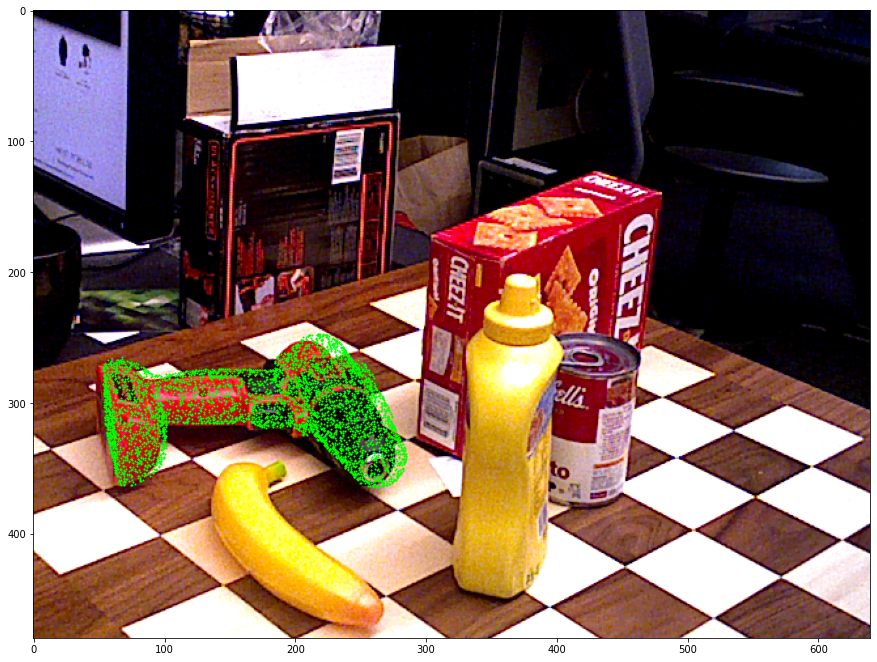

In [26]:
#TODO - rzutowanie chmury punktow
projection_points = project(pose, model_ply, camera_matrix)

plt.figure(figsize=(15, 13))
plt.imshow(trainImg)
plt.scatter(projection_points[:, 0], projection_points[:, 1], s=1, c='lime')

plt.show()

In [34]:
#TODO - rzutowanie prostopadloscianu
x_min, x_max = np.min(model_ply[:, 0]), np.max(model_ply[:, 0])
y_min, y_max = np.min(model_ply[:, 1]), np.max(model_ply[:, 1])
z_min, z_max = np.min(model_ply[:, 2]), np.max(model_ply[:, 2])

model_cuboid = np.array([
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max],
])

model_cuboid_edges_points = np.array([
    [0, 1], [1, 2], [2, 3], [3, 0],
    [0, 4], [1, 5], [2, 6], [3, 7],
    [4, 5], [5, 6], [6, 7], [7, 4]
])

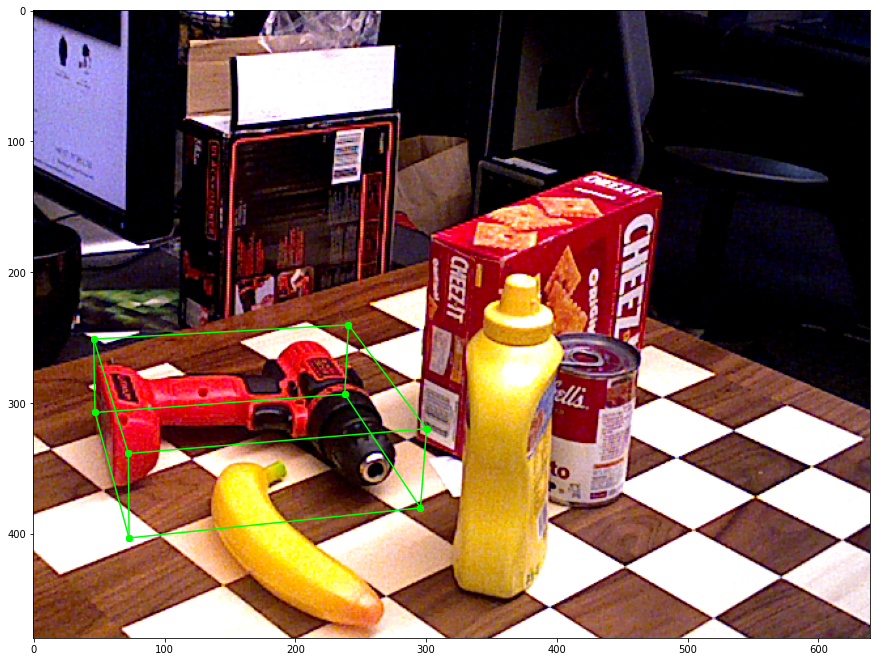

In [36]:
projection_cuboid = project(pose, model_cuboid, camera_matrix)

plt.figure(figsize=(15, 13))
plt.imshow(trainImg)
for a_idx, b_idx in model_cuboid_edges_points:
    a, b = projection_cuboid[a_idx], projection_cuboid[b_idx]
    plt.plot([a[0], b[0]], [a[1], b[1]], c='lime', marker='o')

# ADD Metric

- średnia odległość pomiędzy punktami dla wyznaczonej pozy i GT (w przestrzeni 3D)
- obiekt jest obracany oraz transponowany 
- akceptowalna poza poniżej 10% średnicy obiektu


### 10% maksymalnej odległości w obiekcie

In [37]:
add_metric = np.sqrt((np.max(model_ply[:,0])-np.min(model_ply[:,0]))**2+(np.max(model_ply[:,1])-np.min(model_ply[:,1]))**2+(np.max(model_ply[:,2])-np.min(model_ply[:,2]))**2)/10
print(add_metric)

0.026833180743021573


In [38]:
from scipy.spatial.transform import Rotation as R

def add(rot, rot_gt, model): 
    pts_est = transform_points(model,rot)
    pts_gt = transform_points(model,rot_gt)
    diff = pts_est - pts_gt
    error = np.mean(np.sqrt(np.sum(diff**2, axis=1)))
    return error
    
def transform_points(model,rot):
    model_2 = np.ones((model.shape[0],4))
    model_2[:,:3] = model
    pts_new =  model_2.dot(rot.T)
    return pts_new

def count_add(GT, pose_estimation, model_ply):
 
    rot_gt = np.zeros((3,4))
    r = R.from_quat(GT[:4])
    rot_gt[:,:3] = r.as_matrix()
    rot_gt[:,3] = GT[4:] #translacja

    rot = np.zeros((3,4))
    r = R.from_quat(pose_estimation[:4])
    rot[:,:3] = r.as_matrix()
    rot[:,3] = pose_estimation[4:]

    return add(rot,rot_gt,model_ply)


Identyczna poza:

In [39]:
count_add(np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.96002502]),
          np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.96002502]),
         model_ply)

0.0

Poza przesunięta o 1cm:

In [40]:
count_add(np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.96002502]),
          np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.97002502]),
         model_ply)

0.01000000000000001

# ADD-S Metric

- wersja dla obiektów symetrycznych
- średnia odległość pomiędzy najbliższymi punktami


### 10% maksymalnej odległości w obiekcie

In [41]:
add_metric = np.sqrt((np.max(model_ply[:,0])-np.min(model_ply[:,0]))**2+(np.max(model_ply[:,1])-np.min(model_ply[:,1]))**2+(np.max(model_ply[:,2])-np.min(model_ply[:,2]))**2)/10
print(add_metric)

0.026833180743021573


In [42]:
def adds(rot, rot_gt, model):
    """
    Average Distance of Model Points for objects with indistinguishable views
    - by Hinterstoisser et al. (ACCV 2012).
    :param R_est, t_est: Estimated pose (3x3 rot. matrix and 3x1 trans. vector).
    :param R_gt, t_gt: GT pose (3x3 rot. matrix and 3x1 trans. vector).
    :param model: Object model given by a dictionary where item 'pts'
    is nx3 ndarray with 3D model points.
    :return: Error of pose_est w.r.t. pose_gt.
    """
    pts_est = transform_points(model, rot)
    pts_gt = transform_points(model, rot_gt)

    # Calculate distances to the nearest neighbors from pts_gt to pts_est
    nn_index = spatial.cKDTree(pts_est)
    nn_dists, _ = nn_index.query(pts_gt, k=1)

    e = nn_dists.mean()
    return e


# Reprojection Error

- błąd po rzutowaniu punktów na zdjęcie - przy pomocy macierzy kamery
- średni błąd w pikselach pomiędzy rzutowanym punktem z modelu dla predykcji i GT


In [43]:
from scipy.spatial.transform import Rotation as R

def rep_err(rot, rot_gt, model): 
    pts_est = transform_points_rep(model,rot)
    pts_gt = transform_points_rep(model,rot_gt)
    diff = pts_est - pts_gt
    error = np.mean(np.sqrt(np.sum(diff**2, axis=0)))
    return error
    
def transform_points_rep(model,rot):
    model_2 = np.ones((model.shape[0],4))
    model_2[:,:3] = model
    pts_new = camera_matrix @ rot @ model_2.T
    pts_new[:2] = pts_new[:2] / pts_new[2]
    return pts_new[:2]

def count_rep_err(GT, pose_estimation, model_ply):
 
    rot_gt = np.zeros((3,4))
    r = R.from_quat(GT[:4])
    rot_gt[:,:3] = r.as_matrix()
    rot_gt[:,3] = GT[4:] #translacja

    rot = np.zeros((3,4))
    r = R.from_quat(pose_estimation[:4])
    rot[:,:3] = r.as_matrix()
    rot[:,3] = pose_estimation[4:]

    return rep_err(rot,rot_gt,model_ply)


In [44]:
count_rep_err(np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.96002502]),
          np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.96002502]),
         model_ply)

0.0

In [45]:
count_rep_err(np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.96002502]),
          np.array([ 0.30252337,  0.47923383,  0.65295039, -0.49823426, -0.11094919,  0.05704401, 0.97002502]),
         model_ply)

1.636332569435939